# HPO with dask-ml and cuml

## Introduction

&emsp; &emsp; &emsp; [Hyperparameter optimization](https://cloud.google.com/ai-platform/training/docs/hyperparameter-tuning-overview) is the task of picking the values for the hyperparameters of the model that provide the optimal results for the problem, as measured on a specific test dataset. This is often a crucial step and can help boost the model accuracy when done correctly. Cross-validation is often used to more accurately estimate the performance of the models in the search process. Cross-validation is the method of splitting the training set into complementary subsets and performing training on one of the subsets, then predicting the models performance on the other. This is a potential indication of how the model will generalise to data it has not seen before.

Despite its theoretical importance, HPO has been difficult to implement in practical applications because of the resources needed to run so many distinct training jobs.

The two approaches that we will be exploring in this notebook are :


#### 1. GridSearch

&emsp; &emsp; &emsp; As the name suggests, the "search" is done over each possible combination in a grid of parameters that the user provides. The user must manually define this grid.. For each parameter that needs to be tuned, a set of values are given and the final grid search is performed with tuple having one element from each set, thus resulting in a Catersian Product of the elements.

&emsp; &emsp; &emsp;For example, assume we want to perform HPO on XGBoost. For simplicity lets tune only `n_estimators` and `max_depth`

&emsp; &emsp; &emsp;`n_estimators: [50, 100, 150]`

&emsp; &emsp; &emsp;`max_depth: [6, 7, ,8]`
    
&emsp; &emsp; &emsp; The grid search will take place over |n_estimators| x |max_depth| which is 3 x 3 = 9. As you have probably guessed, the grid size grows rapidly as the number of parameters and their search space increases.

#### 2. RandomSearch


&emsp; &emsp; &emsp; [Random Search](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf) replaces the exhaustive nature of the search from before with a random selection of parameters over the specified space. This method can outperform GridSearch in cases where the number of parameters affecting the model's performance is small (low-dimension optimization problems). Since this does not pick every tuple from the cartesian product, it tends to yield results faster, and the performance can be comparable to that of the Grid Search approach. It's worth keeping in mind that the random nature of this search means, the results with each run might differ.

Some of the other methods used for HPO include:

1. Bayesian Optimization

2. Gradient-based Optimization

3. Evolutionary Optimization

To learn more about HPO, some papers are linked to at the end of the notebook for further reading.

Now that we have a basic understanding of what HPO is, let's discuss what we wish to achieve with this demo. The aim of this notebook is to show the importance of hyper parameter optimisation and the performance of dask-ml GPU for xgboost and cuML-RF and compare the performance with the dask-ml CPU version. We'll highlight the improvements in model performance and the run-time for Grid and Random searches in the CPU and GPU versions.

We make use of the [Higgs dataset](https://archive.ics.uci.edu/ml/datasets/HIGGS). It solves a binary classification problem to distinguish between signal processes that produce Higgs bosons from those that do not. There are a total of 28 features, first 21 are measured and the last 7 are functions of these. It has 11 Million entries.

Let's get started!

In [1]:
import warnings
warnings.filterwarnings('ignore') # Reduce number of messages/warnings displayed

In [2]:
import time

import numpy as np
import cupy as cp
import pandas as pd

import cudf
import cuml
import rmm
import xgboost as xgb

import sklearn.model_selection as sk
import dask_ml.model_selection as dcv
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster

from sklearn import datasets
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score as sk_acc

from cuml.neighbors import KNeighborsClassifier
from cuml.preprocessing.model_selection import train_test_split
from cuml.metrics.accuracy import accuracy_score

import os
from urllib.request import urlretrieve
import gzip

### Spinning up a CUDA Cluster

We start a local cluster and keep it ready for running distributed tasks with dask.


[LocalCUDACluster](https://github.com/rapidsai/dask-cuda) launches one Dask worker for each GPU in the current systems. It's developed as a part of the RAPIDS project.
Learn More:
- [Setting up Dask](https://docs.dask.org/en/latest/setup.html)
- [Dask Client](https://distributed.dask.org/en/latest/client.html)

In [3]:
cluster = LocalCUDACluster(dashboard_address="127.0.0.1:8005")
client = Client(cluster)

client

Client Scheduler: tcp://127.0.0.1:36643 Dashboard: http://127.0.0.1:8005/status,Cluster Workers: 4 Cores: 4 Memory: 404.27 GB


## Data Preparation

We download the Higgs dataset and decompress the file for reading it in as input. We also assign appropriate column names and dtypes.

In [4]:
def download_higgs(compressed_filepath, decompressed_filepath):
    higgs_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz'
    if not os.path.isfile(compressed_filepath):
        urlretrieve(higgs_url, compressed_filepath)
    if not os.path.isfile(decompressed_filepath):
        cf = gzip.GzipFile(compressed_filepath)
        with open(decompressed_filepath, 'wb') as df:
            df.write(cf.read())

In [5]:
data_dir = '/home/hyperopt/data/'
if not os.path.exists(data_dir):
    print('creating data directory')
    os.system('mkdir /home/data/')

In [6]:
compressed_filepath = os.path.join(data_dir, 'HIGGS.csv.gz') # Set this as path for gzipped Higgs data file, if you already have
decompressed_filepath = os.path.join(data_dir, 'HIGGS.csv') # Set this as path for decompressed Higgs data file, if you already have

# Uncomment this line to download the dataset.
# download_higgs(compressed_filepath, decompressed_filepath)

col_names = ['label'] + ["col-{}".format(i) for i in range(2, 30)] # Assign column names
dtypes_ls = ['int32'] + ['float32' for _ in range(2, 30)] # Assign dtypes to each column
input_data = cudf.read_csv(decompressed_filepath, names=col_names, dtype=dtypes_ls)

In [7]:
labels = input_data.label.reset_index().drop(['index'], axis=1)
for col in labels.columns:
    labels[col] = labels[col].astype('float32')
data = input_data.drop(['label'], axis=1)

In [8]:
len(data)

11000000

In [9]:
import time
from contextlib import contextmanager
# Helping time blocks of code
@contextmanager
def timed(txt):
    t0 = time.time()
    yield
    t1 = time.time()
    print("%32s time:  %8.5f" % (txt, t1 - t0))

## Data Fraction

We will make use of `data_fraction` variable that takes value between `(0, 1.0]` to specify the fraction of data to make use. The CPU version crashes when it makes use of larger portion of the dataset, so we will not run the CPU version for a fraction more than `0.1`

In [10]:
data_fraction = 0.1

In [11]:
N_ROWS = int(len(data) * data_fraction)

# Define some default values to make use of across the notebook for a fair comparison
N_FOLDS = 5
N_ESTIMATORS = 100
MAX_DEPTH = 5
N_ITER = 100
print(N_ROWS)

1100000


In [12]:
data = data[:N_ROWS]
labels = labels[:N_ROWS]

## Splitting Data

We split the data randomnly into train and test sets using the [cuml train_test_split](https://rapidsai.github.io/projects/cuml/en/0.12.0/api.html#cuml.preprocessing.model_selection.train_test_split) and create CPU versions of the data.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    labels,
                                                    test_size=0.2)

In [14]:
X_cpu = X_train.to_pandas()
y_cpu = y_train.label.to_array()


X_test_cpu = X_test.to_pandas()
y_test_cpu = y_test.label.to_array()

## Setup Custom cuML scorers

The search functions (such as GridSearchCV) for scikit-learn and dask-ml expect the metric functions (such as accuracy_score) to match the “scorer” API. This can be achieved using the scikit-learn's [make_scorer](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) function.

We will generate a `cuml_scorer` with the cuML `accuracy_score` function.  You'll also notice an `accuracy_score_wrapper` which primarily converts the y label into a `float32` type. This is because some cuML models only accept this type for now and in order to make it compatible, we perform this conversion.

We also create helper functions for performing HPO in 4 different modes: 
1. `gpu-grid`: Perform GPU based GridSearchCV
2. `gpu-random`: Perform GPU based RandomizedSearchCV
3. `cpu-grid`: Perform CPU based GridSearchCV
4. `cpu-random`: Perform CPU based RandomizedSearchCV

In [15]:
def accuracy_score_wrapper(y, y_hat): 
    """
        A wrapper function to convert labels to float32, 
        and pass it to accuracy_score.
        
        Params:
        - y: The y labels that need to be converted
        - y_hat: The predictions made by the model
    """
    y = y.astype("float32") # cuML RandomForest needs the y labels to be float32
    return accuracy_score(y, y_hat, convert_dtype=True)

accuracy_wrapper_scorer = make_scorer(accuracy_score_wrapper)
cuml_accuracy_scorer = make_scorer(accuracy_score, convert_dtype=True)

In [16]:
def do_HPO(model, gridsearch_params, scorer, X, y, mode='gpu-Grid', n_iter=10):
    """
        Perform HPO based on the mode specified
        
        mode: default gpu-Grid. The possible options are:
        1. gpu-grid: Perform GPU based GridSearchCV
        2. gpu-random: Perform GPU based RandomizedSearchCV
        3. cpu-grid: Perform CPU based GridSearchCV
        4. cpu-random: Perform CPU based RandomizedSearchCV
        
        n_iter: specified with Random option for number of parameter settings sampled
        
        Returns the best estimator and the results of the search
    """
    if mode == 'cpu-grid':
        print("cpu-grid selected")
        clf = dcv.GridSearchCV(model,
                              gridsearch_params,
                              cv=N_FOLDS,
                              scoring=scorer)
    elif mode == 'gpu-grid':
        print("gpu-grid selected")
        clf = dcv.GridSearchCV(model,
                               gridsearch_params,
                               cv=N_FOLDS,
                               scoring=scorer)
    elif mode == 'gpu-random':
        print("gpu-random selected")
        clf = dcv.RandomizedSearchCV(model,
                               gridsearch_params,
                               cv=N_FOLDS,
                               scoring=scorer,
                               n_iter=n_iter)
    elif mode == 'cpu-random':
        print("cpu-random selected")
        clf = dcv.RandomizedSearchCV(model,
                               gridsearch_params,
                               cv=N_FOLDS,
                               scoring=scorer,
                               n_iter=n_iter)
    else:
        print("Unknown Option, please choose one of [gpu-grid, gpu-random, cpu-grid, cpu-random]")
        return None, None
    res = clf.fit(X, y)
    print("Best clf and score {} {}\n---\n".format(res.best_estimator_, res.best_score_))
    return res.best_estimator_, res

In [17]:
def print_acc(model, X_train, y_train, X_test, y_test, mode_str="Default"):
    """
        Trains a model on the train data provided, and prints the accuracy of the trained model.
        mode_str: User specifies what model it is to print the value
    """
    y_pred = model.fit(X_train, y_train).predict(X_test)
    score = accuracy_score(y_pred, y_test.astype('float32'), convert_dtype=True)
    
    print("{} model accuracy: {}".format(mode_str, score))
                                         

In [18]:
X_train.shape

(880000, 28)

## Launch HPO

We will first see the model's performances without the gridsearch and then compare it with the performance after searching.

### XGBoost

To perform the Hyperparameter Optimization, we make use of the sklearn version of the [XGBClassifier](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn).We're making use of this version to make it compatible and easily comparable to the scikit-learn version. The model takes a set of parameters that can be found in the documentation. We're primarily interested in the `max_depth`, `learning_rate`, `min_child_weight`, `reg_alpha` and `num_round` as these affect the performance of XGBoost the most.

Read more about what these parameters are useful for [here](https://xgboost.readthedocs.io/en/latest/parameter.html)

We'll first perform the GPU version and then compare it with how long CPU version took to run. We will run only the `dask-ml` GridSearch and RandomSearch in this notebook.


#### Default Performance

We first use the model with it's default parameters and see the accuracy of the model. In this case, it is 71%

In [19]:
model_gpu_xgb_ = xgb.XGBClassifier(tree_method='gpu_hist')

print_acc(model_gpu_xgb_, X_train, y_cpu, X_test, y_test_cpu)

Default model accuracy: 0.7147045731544495


#### Parameter Distributions

The way we define the grid to perform the search is by including ranges of parameters that need to be used for the search. In this example we make use of [np.arange](https://docs.scipy.org/doc/numpy/reference/generated/numpy.arange.html) which returns an ndarray of even spaced values, [np.logspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.logspace.html#numpy.logspace) returns a specified number of ssamples that are equally spaced on the log scale. We can also specify as lists, NumPy arrays or make use of any random variate sample that gives a sample when called. SciPy provides various functions for this too.

In [20]:
# For xgb_model
model_gpu_xgb = xgb.XGBClassifier(tree_method='gpu_hist')

# More range 
params_xgb = {
    "max_depth": np.arange(start=3, stop = 15, step = 3), # Default = 6
    "alpha" : np.logspace(-3, -1, 5), # default = 0
    "learning_rate": [0.05, 0.1, 0.15], #default = 0.3
    "min_child_weight" : np.arange(start=2, stop=10, step=3), # default = 1
    "n_estimators": [100, 200, 1000]
}

#### RandomizedSearchCV

We'll now try [RandomizedSearchCV](https://dask-ml.readthedocs.io/en/latest/modules/generated/dask_ml.model_selection.RandomizedSearchCV.html).
`n_iter` specifies the number of parameters points theat the search needs to perform. Here we will search `N_ITER` (defined earlier) points for the best performance.

In [21]:
mode = "gpu-random"

with timed("XGB-"+mode):
    res, results = do_HPO(model_gpu_xgb,
                                   params_xgb,
                                   cuml_accuracy_scorer,
                                   X_train,
                                   y_cpu,
                                   mode=mode,
                                   n_iter=N_ITER)
print("Searched over {} parameters".format(len(results.cv_results_['mean_test_score'])))


gpu-random selected
Best clf and score XGBClassifier(alpha=0.001, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, learning_rate=0.05, max_delta_step=0,
              max_depth=12, min_child_weight=2, missing=nan, n_estimators=1000,
              n_jobs=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', verbosity=1) 0.7502772559810091
---

                  XGB-gpu-random time:  2124.28109
Searched over 100 parameters


In [22]:
print_acc(res, X_train, y_cpu, X_test, y_test_cpu, mode_str=mode)

gpu-random model accuracy: 0.7528954744338989


In [21]:
mode = "gpu-grid"

with timed("XGB-"+mode):
    res, results = do_HPO(model_gpu_xgb,
                                   params_xgb,
                                   cuml_accuracy_scorer,
                                   X_train,
                                   y_cpu,
                                   mode=mode)
print("Searched over {} parameters".format(len(results.cv_results_['mean_test_score'])))

gpu-grid selected
Best clf and score XGBClassifier(alpha=0.0031622776601683794, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, learning_rate=0.05, max_delta_step=0,
              max_depth=12, min_child_weight=8, missing=nan, n_estimators=1000,
              n_jobs=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', verbosity=1) 0.7505977268241346
---

                    XGB-gpu-grid time:  11913.85282
Searched over 540 parameters


In [22]:
print_acc(res, X_train, y_cpu, X_test, y_test_cpu, mode_str=mode)

gpu-grid model accuracy: 0.7525408864021301


### Improved performance

There's a 4% improvement in the performance.

We notice that performing grid search and random search yields similar performance improvements. We will stick to performing Random Search for the rest of the notebook with the other classifiers with the assumption that there will not be a major difference in performance if the ranges are large enough. 

In order to compare the running time, we will also run the CPU version of this later in the notebook to see what timing improvements look like.

### Visualizing the Search

Let's plot some graphs to get an understanding how the parameters affect the accuracy. The code for these plots are included in `utils.py`

#### Mean/Std of test scores

We fix all parameters except one for each of these graphs and plot the effect the parameter has on the mean test score with the error bar indicating the standard deviation

In [45]:
from utils import *

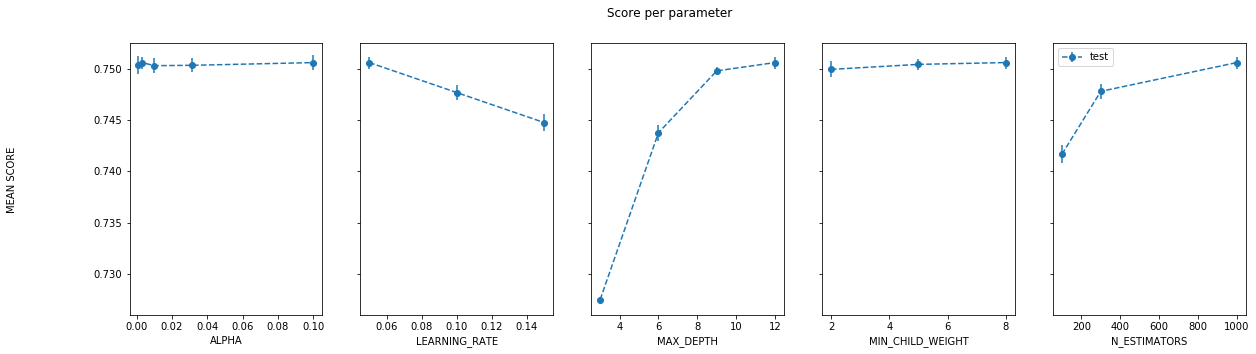

In [24]:
plot_search_results(results)

#### Heatmaps 
   - Between parameter pairs (we can do a combination of all possible pairs, but only one are shown in this notebook) 
   - This gives a visual representation of how the pair affect the test score

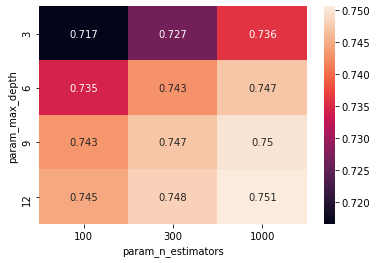

In [26]:
df_gridsearch = pd.DataFrame(results.cv_results_)
plot_heatmap(df_gridsearch, "param_max_depth", "param_n_estimators")

### CPU version

Now, running the model in CPU version to notice the difference in performance in terms of time. The main difference you would notice is that the `tree_method` is set to `hist` instead of `gpu_hist`. The interface remains the same and we can even make use of the same parameters that we defined earlier (in fact, this is necessary for a fair comparison). 

Note: Remember the `data_fraction` flag from earlier and we will ensure we only run the CPU version if we are using less than 1% of the data

In [27]:
if data_fraction <= 0.1:
    model_cpu_xgb = xgb.XGBClassifier(tree_method='hist')

    mode = "cpu-random"
    with timed("XGB-" + mode):
        res, results = do_HPO(model_cpu_xgb,
                   params_xgb,
                   'accuracy',
                   X_cpu,
                   y_cpu,
                   mode=mode,
                   n_iter=N_ITER)
    
    print("Searched over {} parameters".format(len(results.cv_results_['mean_test_score'])))
    
    print_acc(res , X_cpu, y_cpu, X_test_cpu, y_test_cpu,
              mode_str=mode)

cpu-random selected
Best clf and score XGBClassifier(alpha=0.03162277660168379, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, learning_rate=0.05, max_delta_step=0,
              max_depth=12, min_child_weight=8, missing=nan, n_estimators=1000,
              n_jobs=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', verbosity=1) 0.7507897727272728
---

                  XGB-cpu-random time:  27485.06421
Searched over 100 parameters
cpu-random model accuracy: 0.7510272860527039


Remember the GPU version of RandomizedSearch ran in 2124 seconds.

And the CPU version took 27485 seconds over the same number of parameters.

#### We notice a <b> 13x speed-up </b>. 

For the rest of the notebook, we will run just the GPU version. You are free to swap out of the mode to CPU options to see what happens with different models.

#### Running CPU Modes

Each cell that calls this `do_HPO` function has a `mode` variable defining what task we want it to perform. 

1. For CPU experiments, use `cpu-random` or `cpu-grid` depending of which experiment you wish to run. 

2. If you make use of `cpu-random`, specify `n_iter` for number of parameter combinations to consider. It defaults to just 10.

3. For CPU modes, the scorer we use is the default 'accuracy' metric.

<b> DO NOT</b> use `cuml_scorer` or the `accuracy_wrapper_scorer` both of these are used for the GPU options.

#### Runtime observations
These are the observed runtimes for different runs with different combinations. All of these are run on 4 Tesla T4 GPUs 16GB RAM. You will notice that some of the combinations do not have a CPU runtime comparison, this was intentionally done to avoid the redundancy in experiments and prevent the kernel crashing.

| data_fraction | parameters | GPU Time |CPU Time
|---------------|------------| ------|---|
|0.01|100|258.98545|1131.57301|
| |180|380.23315|2079.6394|
||240|616.53354|-|
|0.1|100|705.42218|9832.40570|
||270|1998.64815|-|
|0.5|250|4909.64941|-|
|0.7|180|5696.12868|-|

We are searching over a small space because we want to compare with the CPU version, it is recommended that you change the following values to observe changes in performance:

1. `data_fraction` >= 0.5
2. Increase parameter ranges to search over 1000 parameters and `N_ITER` >= 400

### KNNClassifier

We are going to now perform HPO with [cuml-KNNClassifier](https://rapidsai.github.io/projects/cuml/en/0.12.0/api.html#cuml.neighbors.KNeighborsClassifier). We will again note the default performance and notice what HPO does to improve this.

We will run GridSearch for KNN because we are tuning just one parameter, which is `n_neighbors`, this defines the number of neighbors to consider for the classification.

We plot a simple 2D plot to observe the effect of neighbors on accuracy.

In [28]:
# KNN-Classifier
model_knn_ = KNeighborsClassifier(n_neighbors=5)

model_knn_.fit(X_train, y_train)
print("Default accuracy {}".format(accuracy_score(model_knn_.predict(X_test), y_test)))

Default accuracy 0.625322699546814


In [29]:
model_knn = KNeighborsClassifier(n_neighbors=5)

ks = [i for i in range(1, 40)]
params_knn = {'n_neighbors': ks
             }

mode = "gpu-grid"
with timed("KNN-"+mode):
    res, results = do_HPO(model_knn,
               params_knn,
               cuml_accuracy_scorer,
               X_train,
               y_cpu.astype('int32'),
                mode=mode)


gpu-grid selected
Best clf and score KNeighborsClassifier(weights='uniform') 0.6498602271080017
---

                    KNN-gpu-grid time:  351.95597


In [30]:
res.fit(X_train, y_train)
print("{} accuracy {}".format(mode, accuracy_score(res.predict(X_test), y_test)))

gpu-grid accuracy 0.6510545611381531


In [34]:
df = pd.DataFrame(results.cv_results_)

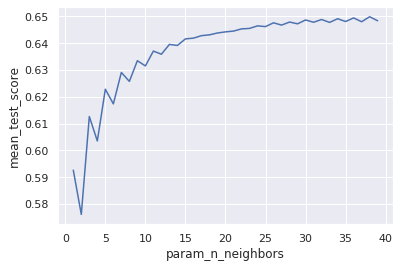

In [43]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
sns.lineplot(x="param_n_neighbors", y="mean_test_score", data=df)

We notice a 3% increase in the accuracy. 


## Conclusion and Next Steps

We notice improvements in the performance for a really basic version of the GridSearch and RandomizedSearch on just 10% of the data. Generally, the more data we use, the better the model performs, so you are encouraged to try for larger data and broader range of parameters.

This experiment can also be repeated with different classifiers and different ranges of parameters to notice how HPO can help improve the performance metric. In this example, we have chosen a basic metric - accuracy, but you can use more interesting metrics that help in determining the usefulness of a model. You can even send a list of parameters to the scoring function. This makes HPO really powerful, and it can add a significant boost to the model that we generate.


#### Further Reading

- [The 5 Classification Evaluation Metrics You Must Know](https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226)
- [11 Important Model Evaluation Metrics for Machine Learning Everyone should know](https://www.analyticsvidhya.com/blog/2019/08/11-important-model-evaluation-error-metrics/)
- [Algorithms for Hyper-Parameter Optimisation](http://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)
- [Forward and Reverse Gradient-Based Hyperparameter Optimization](http://proceedings.mlr.press/v70/franceschi17a/franceschi17a-supp.pdf)
- [Practical Bayesian Optimization of Machine
Learning Algorithms](http://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf)
- [Random Search for Hyper-Parameter Optimization](http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf)